In [1]:
!pip install fakeredis redis matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.6/119.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.2/354.2 kB 9.1 MB/s eta 0:00:00


In [2]:
import time
import redis
import fakeredis
import matplotlib.pyplot as plt
from datetime import datetime

class RealtimeSystem:
    """
    Система реального времени на Redis.
    Использует fakeredis для эмуляции сервера в памяти.
    """

    def __init__(self):
        # Подключение к эмулированному Redis
        self.redis = fakeredis.FakeStrictRedis(decode_responses=True)
        print("✅ Система запущена (Redis in-memory)")

    # --- МОДУЛЬ 1: ОНЛАЙН-СТАТУСЫ ---
    def heartbeat(self, user_id: str, ttl: int = 60):
        """Пинг активности пользователя."""
        now = time.time()
        # ZADD: добавляем ID пользователя с текущим временем в качестве score
        self.redis.zadd('users:online', {user_id: now})

        # Очистка: удаляем всех, кто был активен раньше чем (сейчас - ttl)
        cutoff = now - ttl
        self.redis.zremrangebyscore('users:online', 0, cutoff)

    def get_online_users(self) -> list:
        """Получить список активных пользователей."""
        # Для гарантии актуальности можно вызвать очистку перед чтением
        cutoff = time.time() - 60
        self.redis.zremrangebyscore('users:online', 0, cutoff)
        return self.redis.zrange('users:online', 0, -1)

    # --- МОДУЛЬ 2: RATE LIMITING (Sliding Window Log) ---
    def check_limit(self, user_id: str, limit: int = 5, window: int = 10):
        """
        Проверка лимита: разрешено ли действие?
        Returns: (is_allowed, current_count)
        """
        key = f'ratelimit:{user_id}'
        now = time.time()
        window_start = now - window

        with self.redis.pipeline() as pipe:
            # 1. Удаляем устаревшие записи (старше окна)
            pipe.zremrangebyscore(key, 0, window_start)

            # 2. Считаем количество оставшихся записей в текущем окне
            pipe.zcard(key)

            # 3. Добавляем текущий запрос (пока просто записываем факт попытки)
            # В реальной системе можно добавлять только если лимит не превышен,
            # но для Sliding Log обычно пишут все попытки или используют Lua-скрипт.
            # Здесь для простоты мы сначала посчитаем (шаг 2), а решение примем ниже.
            pipe.zadd(key, {str(now): now})

            # 4. Обновляем TTL ключа (чтобы мусор не копился вечно)
            pipe.expire(key, window + 1)

            results = pipe.execute()

        current_count_in_window = results[1]

        # Если количество записей ДО текущей попытки меньше лимита -> Разрешено
        if current_count_in_window < limit:
            return True, current_count_in_window + 1
        else:
            # Лимит превышен. Мы уже добавили "лишнюю" запись в шаге 3,
            # в строгой реализации её можно было бы удалить, но для логов это не критично.
            return False, current_count_in_window + 1

# --- СИМУЛЯЦИЯ И ВИЗУАЛИЗАЦИЯ ---

def run_simulation():
    system = RealtimeSystem()
    user = "active_user_1"
    limit = 5

    print(f"\n🚀 Запуск стресс-теста Rate Limiter для пользователя '{user}'")
    print(f"Ограничение: {limit} запросов в 10 секунд.\n")

    history = [] # Для хранения результатов (время, статус, нагрузка)
    start_time = time.time()

    # Симулируем серию запросов в течение 15 секунд
    # Пользователь делает запрос каждые 0.8 секунды (быстрее лимита)
    for i in range(20):
        is_allowed, count = system.check_limit(user, limit=limit, window=10)

        status = "OK" if is_allowed else "BLOCKED"
        timestamp = time.time() - start_time

        history.append({
            'time': timestamp,
            'allowed': is_allowed,
            'count': count
        })

        symbol = "✅" if is_allowed else "⛔"
        print(f"[{timestamp:.1f}s] Запрос #{i+1}: {symbol} {status} (Нагрузка: {count}/{limit})")

        # Пауза между запросами
        time.sleep(0.8)

    return history, limit

✅ Система запущена (Redis in-memory)

🚀 Запуск стресс-теста Rate Limiter для пользователя 'active_user_1'
Ограничение: 5 запросов в 10 секунд.

[0.0s] Запрос #1: ✅ OK (Нагрузка: 1/5)
[0.8s] Запрос #2: ✅ OK (Нагрузка: 2/5)
[1.6s] Запрос #3: ✅ OK (Нагрузка: 3/5)
[2.4s] Запрос #4: ✅ OK (Нагрузка: 4/5)
[3.2s] Запрос #5: ✅ OK (Нагрузка: 5/5)
[4.0s] Запрос #6: ⛔ BLOCKED (Нагрузка: 6/5)
[4.8s] Запрос #7: ⛔ BLOCKED (Нагрузка: 7/5)
[5.6s] Запрос #8: ⛔ BLOCKED (Нагрузка: 8/5)
[6.4s] Запрос #9: ⛔ BLOCKED (Нагрузка: 9/5)
[7.2s] Запрос #10: ⛔ BLOCKED (Нагрузка: 10/5)
[8.0s] Запрос #11: ⛔ BLOCKED (Нагрузка: 11/5)
[8.8s] Запрос #12: ⛔ BLOCKED (Нагрузка: 12/5)
[9.6s] Запрос #13: ⛔ BLOCKED (Нагрузка: 13/5)
[10.4s] Запрос #14: ⛔ BLOCKED (Нагрузка: 13/5)
[11.2s] Запрос #15: ⛔ BLOCKED (Нагрузка: 13/5)
[12.0s] Запрос #16: ⛔ BLOCKED (Нагрузка: 13/5)
[12.9s] Запрос #17: ⛔ BLOCKED (Нагрузка: 13/5)
[13.7s] Запрос #18: ⛔ BLOCKED (Нагрузка: 13/5)
[14.5s] Запрос #19: ⛔ BLOCKED (Нагрузка: 13/5)
[15.3s] Запрос #20:

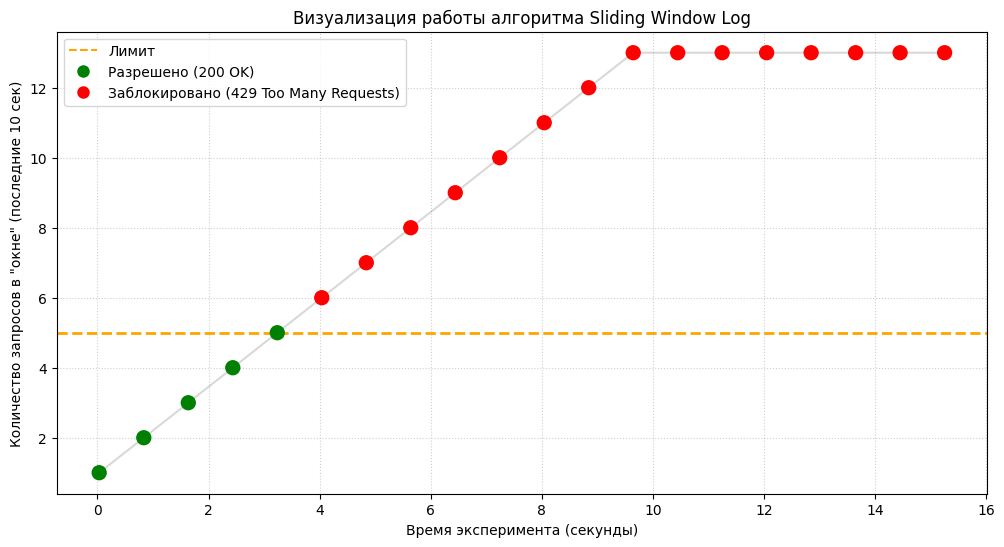

In [3]:
# Запуск и построение графика
data, limit_val = run_simulation()

# Подготовка данных для графика
times = [d['time'] for d in data]
counts = [d['count'] for d in data]
colors = ['green' if d['allowed'] else 'red' for d in data]

plt.figure(figsize=(12, 6))

# Рисуем линию лимита
plt.axhline(y=limit_val, color='orange', linestyle='--', label='Лимит (5 запросов)', linewidth=2)

# Рисуем запросы
plt.scatter(times, counts, c=colors, s=100, zorder=10)
plt.plot(times, counts, color='gray', alpha=0.3) # Линия соединения для наглядности

# Легенда и оформление
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='orange', linestyle='--', label='Лимит'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Разрешено (200 OK)', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Заблокировано (429 Too Many Requests)', markersize=10)
]
plt.legend(handles=legend_elements)

plt.title('Визуализация работы алгоритма Sliding Window Log')
plt.xlabel('Время эксперимента (секунды)')
plt.ylabel('Количество запросов в "окне" (последние 10 сек)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()